### Importing Libraries

In [ ]:
import pandas as pd
import os
import pickle
import keras
import numpy as np
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from google.colab import drive
drive.mount('/content/drive')

### Data Preprocessing

In [ ]:
class AudioProcessing():

    @staticmethod
    def open(audio_file_path):
        data, sampling_rate = torchaudio.load(audio_file_path)
        return (data, sampling_rate)

    #channels stereo/mono
    @staticmethod
    def rechannel(audio_file, new_channel):
        data, sampling_rate = audio_file

        if (data.shape[0] == new_channel):
            return audio_file

        if (new_channel == 1):
          # stereo to mono
          resig = data[:1, :]
        else:
          # mono to stereo by duplicating
          resig = torch.cat([data, data])

        return ((resig, sampling_rate))

#resample one at a time and merge
    @staticmethod
    def resample(audio, new_sampling_rate):
        data, sampling_rate = audio

        if (sampling_rate == new_sampling_rate):
            return audio

        num_channels = data.shape[0]
        resig = torchaudio.transforms.Resample(sampling_rate, new_sampling_rate)(data[:1,:])
        if (num_channels > 1):
            retwo = torchaudio.transforms.Resample(sampling_rate, new_sampling_rate)(data[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, new_sampling_rate))

    @staticmethod
    def pad_trunc(audio, max_ms):
        data, sampling_rate = audio
        num_rows, data_len = data.shape
        max_len = sampling_rate//1000 * max_ms

        if (data_len > max_len):
          # truncate to given length
          data = data[:,:max_len]

        elif (data_len < max_len):
          # padding at the start and end of the audio
            pad_begin_len = random.randint(0, max_len - data_len) #fill with random no between at 0 upto the extra time(maxlen-datalen)
            pad_end_len = max_len - data_len - pad_begin_len

          # Pad with 0s - Zero Padding
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            data = torch.cat((pad_begin, data, pad_end), 1)

        return (data, sampling_rate)


  # Spectrogram!!!

    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)

def data_processing(folder):
    spectrograms = []
    new_channel = 2                   #making all stereo sounds
    new_sampling_rate = 44100         #permanently setting a standard rate
    duration = 6000                   #setting a standard audio length of 6s, 6000ms

  # looping over every file in the folder of musical instrument.
    for i in os.listdir(folder):

        audio = AudioProcessing.open(os.path.join(folder,i))
        resampled_audio = AudioProcessing.resample(audio, new_sampling_rate)
        rechanneled_audio = AudioProcessing.rechannel(resampled_audio, new_channel)
        padded_audio = AudioProcessing.pad_trunc(rechanneled_audio, duration)
        spectro_gram = AudioProcessing.spectro_gram(padded_audio, n_mels=64, n_fft=1024, hop_len=None)
        spectrograms.append(spectro_gram)

    return spectrograms


### Data Load

In [ ]:
# Define a list of categories
categories = [
    'sitar',
    'tabla',
    'harmonium',
    'bansuri',
    'sitar-tabla',
    'sitar-harmonium',
    'sitar-bansuri',
    'tabla-harmonium',
    'tabla-bansuri',
    'harmonium-bansuri',
    'sitar-tabla-harmonium',
    'sitar-tabla-bansuri',
    'sitar-harmonium-bansuri',
    'tabla-harmonium-bansuri',
    'sitar-tabla-harmonium-bansuri'
]

# Initialize an empty list to store the input data
x = []
category_x = {}
category_y = {}
# Initialize an empty list to store the output labels
y = []

# Iterate over the categories
for idx, category in enumerate(categories):
    print(category)
    category_x[category] = []
    category_y[category] = []

    # Define the Google Drive path for the category
    google_drive_path = f'/content/drive/My Drive/deep-learning/Project/Code/data/{category}'

    # Process data for the category
    category_spectrograms = data_processing(google_drive_path)

    # Convert the data to numpy arrays
    category_arr_list = []
    for i in category_spectrograms:
        arr = i.numpy()
        category_arr_list.append(arr)
        # Append the category to the output list
        y.append(idx)
        category_y[category].append(idx)

    category_arr = np.array(category_arr_list)

    # Append the data to the input list
    x.append(category_arr)
    category_x[category].append(category_arr)

# Save x, y, category_x, category_y to a file
data_to_save = {
    'x': x,
    'y': y,
    'category_x': category_x,
    'category_y': category_y
}

# Define the path to save the file on Google Drive
save_path = '/content/drive/My Drive/deep-learning/Project/Code/data/saved_data.pkl'

# Open the file in binary write mode and save the data
with open(save_path, 'wb') as file:
    pickle.dump(data_to_save, file)

# Print a message to confirm that the data has been saved
print(f'Data saved to {save_path}')

sitar
tabla
harmonium
bansuri
sitar-tabla
sitar-harmonium
sitar-bansuri
tabla-harmonium
tabla-bansuri
harmonium-bansuri
sitar-tabla-harmonium
sitar-tabla-bansuri
sitar-harmonium-bansuri
tabla-harmonium-bansuri
sitar-tabla-harmonium-bansuri
Data saved to /content/drive/My Drive/deep-learning/Project/Code/data/saved_data.pkl


In [ ]:
save_path = '/content/drive/My Drive/deep-learning/Project/Code/data/saved_data.pkl'

# Load data from the saved file
with open(save_path, 'rb') as file:
    loaded_data = pickle.load(file)

# Access the variables from the loaded data
x = loaded_data['x']
y = loaded_data['y']
category_x = loaded_data['category_x']
category_y = loaded_data['category_y']

### Test Train Split

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
# # Convert x and y to numpy arrays
y = np.array(y)
y = y.reshape(len(y),1)
x = np.concatenate(x, axis=0)
x = x.astype(float)/255 #standardisation

# # Shuffle the data
x, y = shuffle(x, y, random_state=42)

# # Convert y to one-hot encoding
y = to_categorical(y)

print(x.shape) #m, nx
print(y.shape) #m, no of classes

# Split the data into training and testing sets
split_ratio = 0.8  # 80% training, 20% testing
split_idx = int(len(x) * split_ratio)

x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


(6033, 2, 64, 516)
(6033, 15)


### CNN

In [ ]:
from tensorflow.keras import layers, models, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

model1=Sequential()
model1.add(layers.InputLayer(input_shape=(2, 64, 516)))
model1.add(layers.Permute((2, 3, 1)))
model1.add(Conv2D(32,(3,3), activation="relu",padding='same'))
model1.add(MaxPooling2D(pool_size =(2,2)))
model1.add(Conv2D(64,(2,2),activation="relu",padding='same'))
model1.add(MaxPooling2D(pool_size =(2,2)))
model1.add(Conv2D(128,(2,2),activation="relu",padding='same'))
model1.add(MaxPooling2D(pool_size =(2,2)))
model1.add(Conv2D(256,(2,2),activation="relu",padding='same'))
model1.add(MaxPooling2D(pool_size =(2,2)))
model1.add(Flatten())
model1.add(Dense(256,activation="relu"))
# Change Dense Layer Input to number of classes.
model1.add(Dense(15,activation='relu'))

model1.summary()

model1.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001),
              loss = "binary_crossentropy", metrics =["accuracy", ])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 64, 516, 2)        0         
                                                                 
 conv2d (Conv2D)             (None, 64, 516, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 258, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 258, 64)       8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 129, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 129, 128)      3

# Literature Reviewe CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Permute


model = Sequential()
model.add(InputLayer(input_shape=(2, 64, 516)))
model.add(Permute((2, 3, 1)))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(15))
model.add(Activation('softmax'))
print(model.summary())

model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 64, 516, 2)        0         
                                                                 
 conv2d (Conv2D)             (None, 62, 514, 32)       608       
                                                                 
 activation (Activation)     (None, 62, 514, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 512, 32)       9248      
                                                                 
 activation_1 (Activation)   (None, 60, 512, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 170, 32)       0         
 D)                                                              
                                                        

# **Training and Testing Different Learning Rates**

## Learning Rate = 0.001

In [ ]:
from keras.models import load_model

model_path = '/content/drive/My Drive/deep-learning/Project/Code/models/model_lr_0.001_epochs.h5'

model1 = load_model(model_path)

In [ ]:
history = model1.fit(x_train, y_train, epochs=10,batch_size=32)
model1.save('/content/drive/My Drive/deep-learning/Project/Code/models/model_lr_0.001_epochs.h5')

Epoch 1/10
151/151 [==============================] - 21s 47ms/step - loss: 0.1800 - accuracy: 0.4345
Epoch 2/10
151/151 [==============================] - 5s 36ms/step - loss: 0.0730 - accuracy: 0.8052
Epoch 3/10
151/151 [==============================] - 5s 36ms/step - loss: 0.0443 - accuracy: 0.8960
Epoch 4/10
151/151 [==============================] - 6s 36ms/step - loss: 0.0322 - accuracy: 0.9233
Epoch 5/10
151/151 [==============================] - 5s 35ms/step - loss: 0.0254 - accuracy: 0.9387
Epoch 6/10
151/151 [==============================] - 6s 37ms/step - loss: 0.0191 - accuracy: 0.9532
Epoch 7/10
151/151 [==============================] - 6s 37ms/step - loss: 0.0152 - accuracy: 0.9650
Epoch 8/10
151/151 [==============================] - 5s 36ms/step - loss: 0.0108 - accuracy: 0.9762
Epoch 9/10
151/151 [==============================] - 6s 38ms/step - loss: 0.0091 - accuracy: 0.9811
Epoch 10/10
151/151 [==============================] - 5s 36ms/step - loss: 0.0080 - accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import matplotlib.pyplot as plt

#model accuracy
print(history.history)
plt.plot(history.history['accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

#model loss
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

38/38 [==============================] - 1s 16ms/step
Precision: 0.9397731998246611
Recall: 0.9403479701739851
F1 Score: 0.9393963091584236


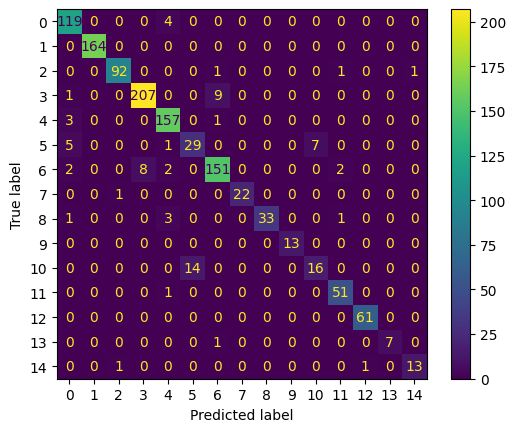

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = model1.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

ConfusionMatrixDisplay.from_predictions(
y_true_labels, y_pred_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
print(classification_report(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       123
           1       1.00      1.00      1.00       164
           2       0.98      0.97      0.97        95
           3       0.96      0.95      0.96       217
           4       0.93      0.98      0.95       161
           5       0.67      0.69      0.68        42
           6       0.93      0.92      0.92       165
           7       1.00      0.96      0.98        23
           8       1.00      0.87      0.93        38
           9       1.00      1.00      1.00        13
          10       0.70      0.53      0.60        30
          11       0.93      0.98      0.95        52
          12       0.98      1.00      0.99        61
          13       1.00      0.88      0.93         8
          14       0.93      0.87      0.90        15

    accuracy                           0.94      1207
   macro avg       0.93      0.90      0.91      1207
weighted avg       0.94   

## Learning Rate = 0.01

In [ ]:
from keras.models import load_model

model_path = '/content/drive/My Drive/deep-learning/Project/Code/models/model_lr_0.01_epochs.h5'

model1 = load_model(model_path)

In [ ]:
history_conv = model1.fit(x_train, y_train, epochs=10,batch_size=32)
model1.save('/content/drive/My Drive/deep-learning/Project/Code/models/model_lr_0.01_epochs.h5')

Epoch 1/10
151/151 [==============================] - 22s 45ms/step - loss: 0.2160 - accuracy: 0.2592
Epoch 2/10
151/151 [==============================] - 5s 35ms/step - loss: 0.1381 - accuracy: 0.5533
Epoch 3/10
151/151 [==============================] - 5s 34ms/step - loss: 0.0901 - accuracy: 0.7433
Epoch 4/10
151/151 [==============================] - 5s 36ms/step - loss: 0.0593 - accuracy: 0.8301
Epoch 5/10
151/151 [==============================] - 5s 34ms/step - loss: 0.0426 - accuracy: 0.8873
Epoch 6/10
151/151 [==============================] - 5s 34ms/step - loss: 0.0388 - accuracy: 0.8991
Epoch 7/10
151/151 [==============================] - 6s 37ms/step - loss: 0.0303 - accuracy: 0.9190
Epoch 8/10
151/151 [==============================] - 5s 35ms/step - loss: 0.0236 - accuracy: 0.9364
Epoch 9/10
151/151 [==============================] - 5s 35ms/step - loss: 0.0227 - accuracy: 0.9380
Epoch 10/10
151/151 [==============================] - 6s 37ms/step - loss: 0.0200 - accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


{'loss': [0.2159614861011505, 0.13809973001480103, 0.09011934697628021, 0.05925819277763367, 0.042559005320072174, 0.038771867752075195, 0.030321581289172173, 0.023647647351026535, 0.022703491151332855, 0.019985193386673927], 'accuracy': [0.2592208981513977, 0.5532532334327698, 0.7432656288146973, 0.8300870060920715, 0.8872772455215454, 0.8990882635116577, 0.9189805388450623, 0.936386227607727, 0.9380439519882202, 0.9527559280395508]}


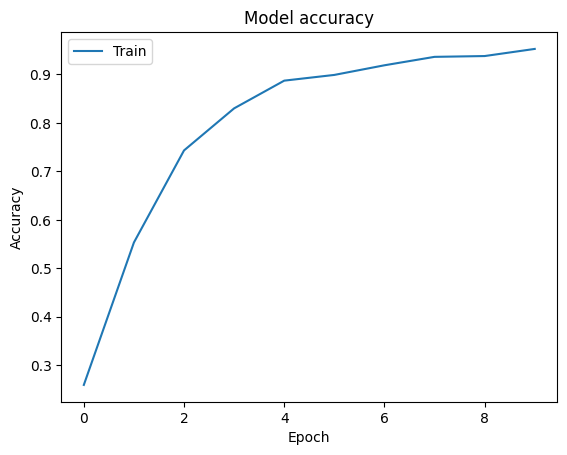

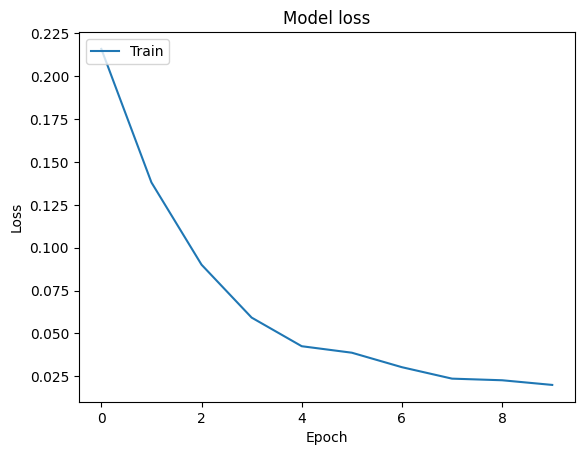

In [ ]:
import matplotlib.pyplot as plt

#model accuracy
print(history_conv.history)
plt.plot(history_conv.history['accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

#model loss
plt.plot(history_conv.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

38/38 [==============================] - 1s 21ms/step
Precision: 0.9107545114797485
Recall: 0.9047224523612262
F1 Score: 0.9056871355804604


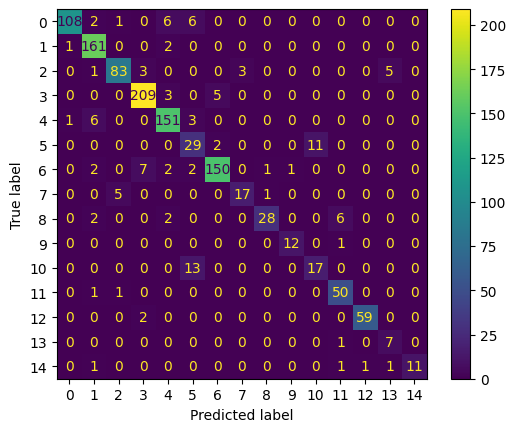

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = model1.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

ConfusionMatrixDisplay.from_predictions(
y_true_labels, y_pred_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Learning Rate = 0.1

In [ ]:
from keras.models import load_model

model_path = '/content/drive/My Drive/deep-learning/Project/Code/models/model_lr_0.1_epochs.h5'

model1 = load_model(model_path)

In [ ]:
history_conv = model1.fit(x_train, y_train, epochs=10,batch_size=32)
model1.save('/content/drive/My Drive/deep-learning/Project/Code/models/model_lr_0.1_epochs.h5')

Epoch 1/10
151/151 [==============================] - 18s 44ms/step - loss: 434.1242 - accuracy: 0.1419
Epoch 2/10
151/151 [==============================] - 5s 35ms/step - loss: 0.2199 - accuracy: 0.1618
Epoch 3/10
151/151 [==============================] - 5s 34ms/step - loss: 0.2200 - accuracy: 0.1668
Epoch 4/10
151/151 [==============================] - 5s 36ms/step - loss: 0.2200 - accuracy: 0.1637
Epoch 5/10
151/151 [==============================] - 6s 36ms/step - loss: 0.2202 - accuracy: 0.1620
Epoch 6/10
151/151 [==============================] - 5s 35ms/step - loss: 0.2202 - accuracy: 0.1631
Epoch 7/10
151/151 [==============================] - 5s 36ms/step - loss: 0.2204 - accuracy: 0.1622
Epoch 8/10
151/151 [==============================] - 5s 35ms/step - loss: 0.2200 - accuracy: 0.1622
Epoch 9/10
151/151 [==============================] - 5s 34ms/step - loss: 0.2200 - accuracy: 0.1593
Epoch 10/10
151/151 [==============================] - 5s 35ms/step - loss: 0.2202 - acc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model1.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# **Training and Testing Different Batch Sizes**

## Batch Size = *64*

In [ ]:
from keras.models import load_model

model_path = '/content/drive/My Drive/deep-learning/Project/Code/models/model_bs_64_epochs.h5'

model1 = load_model(model_path)

In [ ]:
history_conv = model1.fit(x_train, y_train, epochs=10,batch_size=32)
model1.save('/content/drive/My Drive/deep-learning/Project/Code/models/model_lr_64_epochs.h5')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model1.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Batch Size = *128*

In [ ]:
from keras.models import load_model

model_path = '/content/drive/My Drive/deep-learning/Project/Code/models/model_bs_128_epochs.h5'

model1 = load_model(model_path)

In [ ]:
history_conv = model1.fit(x_train, y_train, epochs=10,batch_size=32)
model1.save('/content/drive/My Drive/deep-learning/Project/Code/models/model_lr_128_epochs.h5')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model1.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Batch Size = 256

In [ ]:
from keras.models import load_model

model_path = '/content/drive/My Drive/deep-learning/Project/Code/models/model_bs_256_epochs.h5'

model1 = load_model(model_path)

In [ ]:
history_conv = model1.fit(x_train, y_train, epochs=10,batch_size=32)
model1.save('/content/drive/My Drive/deep-learning/Project/Code/models/model_lr_256_epochs.h5')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model1.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
history = model1.fit(x_train, y_train, epochs=10,batch_size=32)
model1.save('/content/drive/My Drive/deep-learning/Project/Code/models/model_sigmoid_epochs.h5')

Epoch 1/10
151/151 [==============================] - 21s 46ms/step - loss: 0.1871 - accuracy: 0.4068
Epoch 2/10
151/151 [==============================] - 5s 35ms/step - loss: 0.0728 - accuracy: 0.8036
Epoch 3/10
151/151 [==============================] - 5s 36ms/step - loss: 0.0431 - accuracy: 0.8945
Epoch 4/10
151/151 [==============================] - 5s 36ms/step - loss: 0.0301 - accuracy: 0.9310
Epoch 5/10
151/151 [==============================] - 5s 35ms/step - loss: 0.0229 - accuracy: 0.9426
Epoch 6/10
151/151 [==============================] - 5s 36ms/step - loss: 0.0159 - accuracy: 0.9619
Epoch 7/10
151/151 [==============================] - 6s 36ms/step - loss: 0.0116 - accuracy: 0.9743
Epoch 8/10
151/151 [==============================] - 5s 35ms/step - loss: 0.0081 - accuracy: 0.9814
Epoch 9/10
151/151 [==============================] - 5s 36ms/step - loss: 0.0080 - accuracy: 0.9816
Epoch 10/10
151/151 [==============================] - 5s 36ms/step - loss: 0.0074 - accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 1s 19ms/step
Precision: 0.9314616903459626
Recall: 0.9312344656172328
F1 Score: 0.9301761952670273


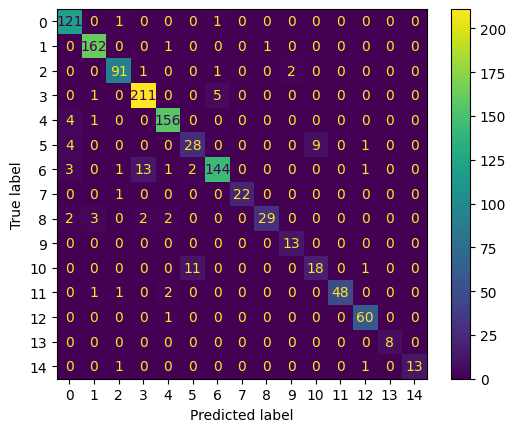

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = model1.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

ConfusionMatrixDisplay.from_predictions(
y_true_labels, y_pred_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
history = model1.fit(x_train, y_train, epochs=10,batch_size=32)
model1.save('/content/drive/My Drive/deep-learning/Project/Code/models/model_relu_epochs.h5')

Epoch 1/10
151/151 [==============================] - 24s 53ms/step - loss: 0.4692 - accuracy: 0.2484
Epoch 2/10
151/151 [==============================] - 5s 35ms/step - loss: 0.3996 - accuracy: 0.3572
Epoch 3/10
151/151 [==============================] - 5s 34ms/step - loss: 0.3583 - accuracy: 0.4534
Epoch 4/10
151/151 [==============================] - 5s 36ms/step - loss: 0.3480 - accuracy: 0.4739
Epoch 5/10
151/151 [==============================] - 5s 34ms/step - loss: 0.2933 - accuracy: 0.5903
Epoch 6/10
151/151 [==============================] - 5s 34ms/step - loss: 0.4142 - accuracy: 0.5218
Epoch 7/10
151/151 [==============================] - 5s 36ms/step - loss: 1.2377 - accuracy: 0.2385
Epoch 8/10
151/151 [==============================] - 5s 35ms/step - loss: 1.3189 - accuracy: 0.1337
Epoch 9/10
151/151 [==============================] - 5s 34ms/step - loss: 0.4343 - accuracy: 0.2426
Epoch 10/10
151/151 [==============================] - 6s 37ms/step - loss: 0.4305 - accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 1s 16ms/step
Precision: 0.28242656159573987
Recall: 0.18972659486329743
F1 Score: 0.13216009183937988


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


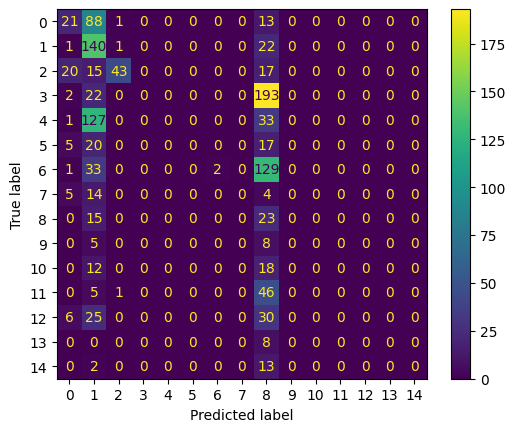

In [ ]:
import matplotlib.pyplot as plt
from sklearn.0metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = model1.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

ConfusionMatrixDisplay.from_predictions(
y_true_labels, y_pred_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Testing Literature Review Model


In [ ]:
history_conv = model.fit(x_train, y_train, epochs=10,batch_size=32)
model.save('/content/drive/My Drive/deep-learning/Project/Code/models/model.h5')

Epoch 1/10
151/151 [==============================] - 28s 78ms/step - loss: 2.2727 - accuracy: 0.2422
Epoch 2/10
151/151 [==============================] - 10s 68ms/step - loss: 1.7097 - accuracy: 0.4082
Epoch 3/10
151/151 [==============================] - 10s 64ms/step - loss: 1.2008 - accuracy: 0.5881
Epoch 4/10
151/151 [==============================] - 10s 66ms/step - loss: 0.8330 - accuracy: 0.7147
Epoch 5/10
151/151 [==============================] - 10s 67ms/step - loss: 0.6138 - accuracy: 0.7880
Epoch 6/10
151/151 [==============================] - 10s 66ms/step - loss: 0.4749 - accuracy: 0.8344
Epoch 7/10
151/151 [==============================] - 10s 67ms/step - loss: 0.3974 - accuracy: 0.8593
Epoch 8/10
151/151 [==============================] - 11s 73ms/step - loss: 0.3365 - accuracy: 0.8755
Epoch 9/10
151/151 [==============================] - 11s 74ms/step - loss: 0.2999 - accuracy: 0.8900
Epoch 10/10
151/151 [==============================] - 12s 80ms/step - loss: 0.262

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


{'loss': [2.2727019786834717, 1.70970618724823, 1.2008310556411743, 0.8329607844352722, 0.6138424873352051, 0.4749017655849457, 0.3973948657512665, 0.3365451991558075, 0.2998930513858795, 0.26257625222206116], 'accuracy': [0.24222959578037262, 0.4082055389881134, 0.5880646705627441, 0.7146705389022827, 0.7880232334136963, 0.8344384431838989, 0.8593037724494934, 0.8754662275314331, 0.8899710178375244, 0.9009531736373901]}


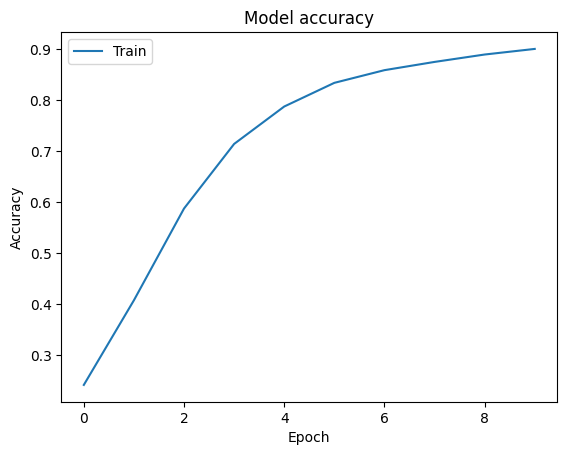

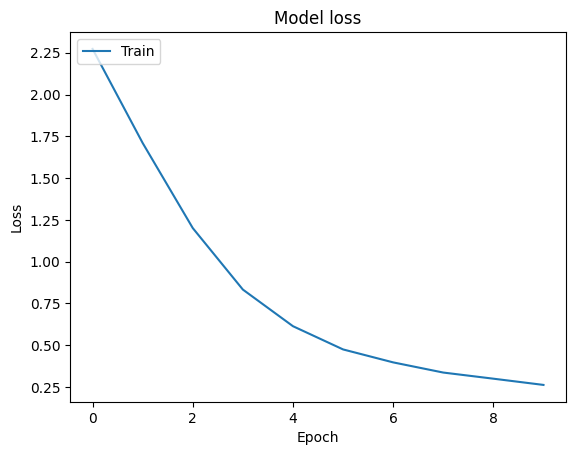

In [ ]:
import matplotlib.pyplot as plt

#model accuracy
print(history_conv.history)
plt.plot(history_conv.history['accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

#model loss
plt.plot(history_conv.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

38/38 [==============================] - 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.8945563725087019
Recall: 0.903893951946976
F1 Score: 0.893342054261103


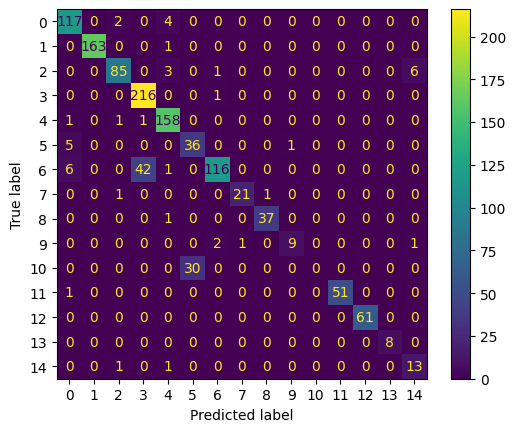

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = model.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

ConfusionMatrixDisplay.from_predictions(
y_true_labels, y_pred_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
print(classification_report(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       123
           1       1.00      0.99      1.00       164
           2       0.94      0.89      0.92        95
           3       0.83      1.00      0.91       217
           4       0.93      0.98      0.96       161
           5       0.55      0.86      0.67        42
           6       0.97      0.70      0.81       165
           7       0.95      0.91      0.93        23
           8       0.97      0.97      0.97        38
           9       0.90      0.69      0.78        13
          10       0.00      0.00      0.00        30
          11       1.00      0.98      0.99        52
          12       1.00      1.00      1.00        61
          13       1.00      1.00      1.00         8
          14       0.65      0.87      0.74        15

    accuracy                           0.90      1207
   macro avg       0.84      0.85      0.84      1207
weighted avg       0.89   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Testing Every Category

In [ ]:
categories = [
    'sitar',
    'tabla',
    'harmonium',
    'bansuri',
    'sitar-tabla',
    'sitar-harmonium',
    'sitar-bansuri',
    'tabla-harmonium',
    'tabla-bansuri',
    'harmonium-bansuri',
    'sitar-tabla-harmonium',
    'sitar-tabla-bansuri',
    'sitar-harmonium-bansuri',
    'tabla-harmonium-bansuri',
    'sitar-tabla-harmonium-bansuri'
]

for i in range(len(categories)):
  print(i, categories[i])

print()
def train_and_evaluate_model(x_train, y_train, x_test, y_test):
    # Evaluation
    y_pred = model1.predict(x_test)

    # Extract predictions for the specific category
    category_index = categories.index(category)
    category_y_test = y_test[:, category_index]
    category_y_pred = y_pred[:, category_index]

    dominant_class_index = np.argmax(y_pred, axis=1)

    print(dominant_class_index)


    accuracy = accuracy_score(category_y_test, np.round(category_y_pred))
    print(f'Category: {category}, Accuracy: {accuracy}')

    return accuracy

# Initialize a dictionary to store results
category_results = {}

# Loop over each category
for category in categories:
    print(f"\nCategory: {category}")

    # Convert x and y to numpy arrays for the specific category
    y_category = np.array(category_y[category])
    y_category = y_category.reshape(len(y_category), 1)
    x_category = np.concatenate(category_x[category], axis=0)
    x_category = x_category.astype(float) / 255  # standardization

    # Shuffle the data
    x_category, y_category = shuffle(x_category, y_category, random_state=42)

    # Convert y to one-hot encoding
    y_category = to_categorical(y_category)

    # Split the data into training and testing sets
    split_ratio = 0.8  # 80% training, 20% testing
    x_train_category, x_test_category, y_train_category, y_test_category = train_test_split(
        x_category, y_category, test_size=0.2, random_state=42
    )

    print(f"Data Shape - Train: {x_train_category.shape}, Test: {x_test_category.shape}")
    results = train_and_evaluate_model(x_train_category, y_train_category, x_test_category, y_test_category)

    # Store the results for later analysis
    category_results[category] = results




0 sitar
1 tabla
2 harmonium
3 bansuri
4 sitar-tabla
5 sitar-harmonium
6 sitar-bansuri
7 tabla-harmonium
8 tabla-bansuri
9 harmonium-bansuri
10 sitar-tabla-harmonium
11 sitar-tabla-bansuri
12 sitar-harmonium-bansuri
13 tabla-harmonium-bansuri
14 sitar-tabla-harmonium-bansuri


Category: sitar


NameError: ignored